In [1]:

import matplotlib.pyplot as plt
import tqdm
import numpy as np

from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.map_expansion import arcline_path_utils
from nuscenes.map_expansion.bitmap import BitMap


Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.195 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.


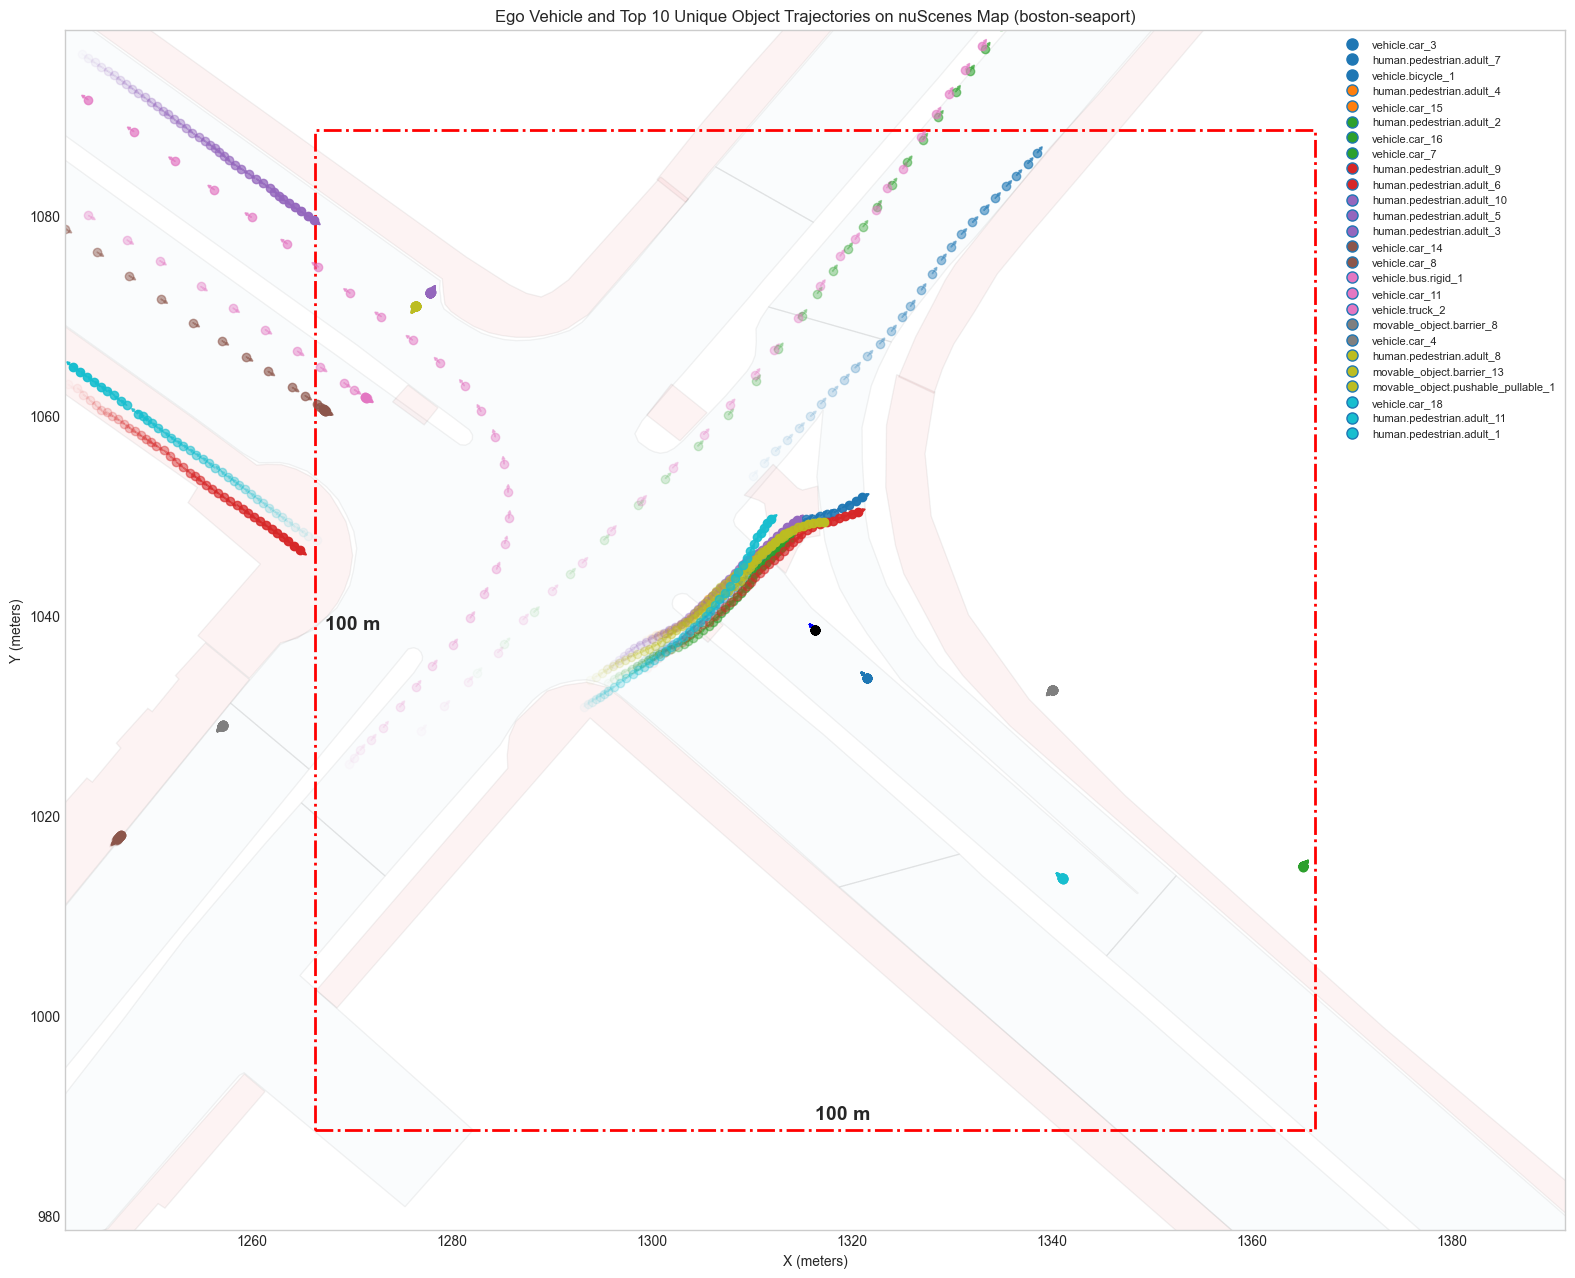

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from nuscenes.nuscenes import NuScenes
from pyquaternion import Quaternion
from collections import defaultdict, OrderedDict
from nuscenes.map_expansion.map_api import NuScenesMap

# Initialize nuScenes dataset
nusc = NuScenes(version='v1.0-mini', dataroot='/Users/liliu/Desktop/Nuscenes/nuscenes', verbose=True)

# Select a scene (second scene)
scene = nusc.scene[2]
first_sample_token = scene['first_sample_token']

# Get the correct map for the scene
log = nusc.get("log", scene["log_token"])
location = log["location"]
nusc_map = NuScenesMap(dataroot='/Users/liliu/Desktop/Nuscenes/nuscenes', map_name=location)

# Store ego trajectory and object trajectories
ego_trajectory = []
ego_orientations = []
timestamps = []

object_trajectories = defaultdict(list)
object_orientations = defaultdict(list)
object_labels = {}

# Function to convert quaternion to 2D yaw angle
def quaternion_to_yaw(quaternion):
    q = Quaternion(quaternion)
    yaw = np.arctan2(2.0 * (q.w * q.z + q.x * q.y), 1.0 - 2.0 * (q.y * q.y + q.z * q.z))
    return yaw

# Track object instances separately
object_name_counter = defaultdict(int)

# Loop through all samples in the scene
sample_token = first_sample_token
while sample_token:
    sample = nusc.get('sample', sample_token)

    # Get timestamp (normalize between 0 and 1 for transparency)
    timestamps.append(sample['timestamp'])

    # Get ego_pose information
    sample_data = nusc.get('sample_data', sample['data']['LIDAR_TOP'])  # Using LiDAR for reference
    ego_pose = nusc.get('ego_pose', sample_data['ego_pose_token'])
    ego_position = tuple(ego_pose['translation'][:2])  # X, Y position
    ego_yaw = quaternion_to_yaw(ego_pose['rotation'])  # Get orientation (yaw)

    ego_trajectory.append(ego_position)
    ego_orientations.append(ego_yaw)

    # Track all objects in the scene
    for ann_token in sample['anns']:
        ann_data = nusc.get('sample_annotation', ann_token)
        instance_token = ann_data['instance_token']
        object_position = tuple(ann_data['translation'][:2])  # Convert to tuple for uniqueness
        object_yaw = quaternion_to_yaw(ann_data['rotation'])  # Get orientation (yaw)

        # Get object category name
        category_name = ann_data['category_name']
        
        # Differentiate identical objects with numbering (_1, _2, ...)
        if instance_token not in object_labels:
            object_name_counter[category_name] += 1
            unique_name = f"{category_name}_{object_name_counter[category_name]}"
            object_labels[instance_token] = unique_name

        # Store object trajectory and orientation
        object_trajectories[instance_token].append(object_position)
        object_orientations[instance_token].append(object_yaw)

    # Move to the next sample
    sample_token = sample['next']

# Normalize timestamps for transparency (0 = oldest, 1 = newest)
timestamps = np.array(timestamps)
timestamps = (timestamps - timestamps.min()) / (timestamps.max() - timestamps.min())  # Normalize between 0 and 1

# Convert ego trajectory to NumPy arrays for plotting
ego_trajectory = np.array(ego_trajectory)
ego_orientations = np.array(ego_orientations)

# **Count unique locations per object (at ranking stage)**
unique_location_counts = {}
filtered_trajectories = {}
filtered_orientations = {}

for instance_token, trajectory in object_trajectories.items():
    unique_locs = OrderedDict()  # Ensure order and store first occurrence of each location
    for i, loc in enumerate(trajectory):
        if loc not in unique_locs:
            unique_locs[loc] = object_orientations[instance_token][i]  # Store first orientation for each unique loc
    
    unique_location_counts[instance_token] = len(unique_locs)  # Count unique locations
    filtered_trajectories[instance_token] = list(unique_locs.keys())  # Store unique locations
    filtered_orientations[instance_token] = list(unique_locs.values())  # Store linked orientations

# **Sort and filter the top 10 longest unique-location trajectories (including ties)**
sorted_lengths = sorted(set(unique_location_counts.values()), reverse=True)  # Get unique lengths, sorted descending

# Keep all objects with trajectory length in the top 10 unique values
if len(sorted_lengths) > 10:
    threshold_length = sorted_lengths[9]  # Get the 10th longest unique length
    selected_instances = {k for k, v in unique_location_counts.items() if v >= threshold_length}
else:
    selected_instances = set(unique_location_counts.keys())  # If fewer than 10 unique lengths, plot all

# Generate distinct colors for selected instances
color_map = cm.get_cmap("tab10", len(selected_instances))
instance_colors = {inst: color_map(i) for i, inst in enumerate(selected_instances)}

# Determine the bounding box for the map (x_min, y_min, x_max, y_max)
x_min, y_min = np.min(ego_trajectory, axis=0) - 50  # Expand by 50m buffer
x_max, y_max = np.max(ego_trajectory, axis=0) + 50  # Expand by 50m buffer
map_bounds = (x_min, y_min, x_max, y_max)

# Define the layer names to be rendered
layer_names = ['drivable_area', 'walkway']

# Render the map patch with 50% transparency
fig, ax = nusc_map.render_map_patch(map_bounds, layer_names, alpha=0.05)

# **Ensure the same distance scale for x and y**
ax.set_aspect('equal')
# Store legend labels
legend_labels = {}

# Plot only the selected top 10 objects with unique colors
# **Apply transparency correctly to instance trajectories**
for instance_token in selected_instances:
    trajectory = np.array(filtered_trajectories[instance_token])
    orientations = np.array(filtered_orientations[instance_token])
    object_name = object_labels[instance_token]
    obj_color = instance_colors[instance_token]

    legend_labels[object_name] = obj_color[:3]  # Store the object name and color for the legend

    for i in range(len(trajectory)):
        alpha = timestamps[i]  # Ensure timestamps are mapped correctly for transparency
        ax.plot(trajectory[i, 0], trajectory[i, 1], marker='o', color=(*obj_color[:3], alpha))  # Correct transparency
        ax.arrow(trajectory[i, 0], trajectory[i, 1],
                 0.5 * np.cos(orientations[i]), 0.5 * np.sin(orientations[i]),
                 head_width=0.3, head_length=0.3, fc=(*obj_color[:3], alpha), ec=(*obj_color[:3], alpha))

# Plot ego trajectory with transparency
for i in range(len(ego_trajectory)):
    alpha = timestamps[i]
    ax.plot(ego_trajectory[i, 0], ego_trajectory[i, 1], marker='o', color=(0, 0, 0, alpha))
    ax.arrow(ego_trajectory[i, 0], ego_trajectory[i, 1],
             0.5 * np.cos(ego_orientations[i]), 0.5 * np.sin(ego_orientations[i]),
             head_width=0.3, head_length=0.3, fc=(0, 0, 1, alpha), ec=(0, 0, 1, alpha))



# Create legend for instances
legend_entries = [plt.Line2D([0], [0], marker='o', markerfacecolor=color, markersize=8, linestyle='None', label=name)
                  for name, color in legend_labels.items()]

# Combine both legends
combined_legend = legend_entries
# Labels and title
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.title(f"Ego Vehicle and Top 10 Unique Object Trajectories on nuScenes Map ({location})")

# Labels and title
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.title(f"Ego Vehicle and Top 10 Unique Object Trajectories on nuScenes Map ({location})")
plt.legend(handles=combined_legend, loc='upper right', fontsize=8)  # Keep both legends
plt.grid()
plt.show()

In [5]:
for i, scene in enumerate(nusc.scene):
    print(f"Scene {i+1}: {scene['name']}")
    print(f"Description: {scene['description']}\n")

Scene 1: scene-0061
Description: Parked truck, construction, intersection, turn left, following a van

Scene 2: scene-0103
Description: Many peds right, wait for turning car, long bike rack left, cyclist

Scene 3: scene-0553
Description: Wait at intersection, bicycle, large truck, peds crossing crosswalk, ped with stroller

Scene 4: scene-0655
Description: Parking lot, parked cars, jaywalker, bendy bus, gardening vehicles

Scene 5: scene-0757
Description: Arrive at busy intersection, bus, wait at intersection, bicycle, peds

Scene 6: scene-0796
Description: Scooter, peds on sidewalk, bus, cars, truck, fake construction worker, bicycle, cross intersection, car overtaking us

Scene 7: scene-0916
Description: Parking lot, bicycle rack, parked bicycles, bus, many peds, parked scooters, parked motorcycle

Scene 8: scene-1077
Description: Night, big street, bus stop, high speed, construction vehicle

Scene 9: scene-1094
Description: Night, after rain, many peds, PMD, ped with bag, jaywalker,